# Quickstart: Amortized Posterior Estimation

## Table of Contents

TBD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

Welcome to the very first tutorial on using BayesFlow for amortized posterior estimation! In this notebook, we will estimate the means of a multivariate Gaussian model and illustrate some features of the library along the way.

Here is a brief description of amortized posterior estimation:

In traditional posterior estimation, as in Bayesian inference, we seek to compute or approximate the posterior distribution of model parameters given observed data for each new data instance separately. This process can be computationally expensive, especially for complex models or large datasets, because it often involves iterative optimization or sampling methods. This step needs to be repeated for each new instance of data.

Amortized posterior estimation offers a solution to this problem. “Amortization” here refers to spreading out the computational cost over multiple instances. Instead of computing a new posterior from scratch for each data instance, amortized inference learns a function. This function is parameterized by a neural network, that directly maps observations to an approximation of the posterior distribution. This function is trained over the dataset to approximate the posterior for any new data instance efficiently. In this example, we will use a simple Gaussian model to illustrate the basic concepts of amortized posterior estimation.

Above, we have already imported the core entities that we will need for this notebook. In brief:

* The module `simulator` contains high-level wrappers for gluing together priors, simulators, and meta-functions, and generating all quantities of interest for a modeling scenario.
* The module `adapters` contains utilities that preprocess the generated data from the simulator to a format more friendly for the neural approximators.
* The module `networks` contains the core neural architecture used for various tasks, e.g., a `FlowMatching` architecture for realizing normalizing flows, or a `DeepSet` for learning permutation-invariant summary representations (embeddings).
* The module `appoximators` contains high-level wrappers which connect the various networks together and instruct them about their particular goals in the inference pipeline.

The nuts and bolts of using BayesFlow for Bayesian parameter estimation have already been described in the corresponding papers:

* TBD
* TBD
* TBD

At a high level, our architecture consists of a summary network $\mathbf{h}$
and an inference network $\mathbf{f}$
which jointly amortize a generative model. The summary network transforms input data $\mathbf{x}$
of potentially variable size to a fixed-length representations. The inference network generates random draws from an approximate posterior $\mathbf{q}$
via a conditional invertible neural network (cINN). This process is illustrated in the figure below:

# Defining the Generative Model

From the perspective of the BayesFlow framework, a generative model is more than just a prior (encoding beliefs about the parameters before observing data) and a simulator (a likelihood function, often implicit, that generates data given parameters). In addition, it consists of various implicit context assumptions, which we can make explicit at any time. Furthermore, we can also amortize over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). We are leveraging the concept of amortized inference and extending it to context variables as well. The figure below illustrates the skeleton of a generative model as conceptualized in the BayesFlow framework.

This conceptual model allows you to tackle very flexible model families with BayesFlow, as well as various other Bayesian tasks, such as prior sensitivity analysis or multiverse analysis.

Prior sensitivity analysis: it is a technique used in Bayesian statistics to assess how sensitive the results of a model are to the choice of the prior distribution. In Bayesian inference, the prior represents our existing knowledge or assumptions about the parameters before observing the data. However, the selection of an appropriate prior can sometimes be subjective, and different priors can lead to different posterior estimates. Prior sensitivity analysis involves systematically varying the priors and examining how these variations affect the posterior estimates.

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

\begin{align}
    \mathbf{\mu} &\sim \mathcal{N}_D(\mathbf{0}, \sigma_0 \mathbb{I}),\\
    \mathbf{x}_n &\sim \mathcal{N}_D(\mathbf{\mu}, \sigma_1 \mathbb{I}) \quad \text{for } n = 1, ..., N,
\end{align}

where $\mathcal{N}_D$
denotes a multivariate Gaussian (normal) density with $D$
dimensions, which we set at $D = 4$
for the current example. For simplicity, we will also set $\sigma_0 = 1$
and $\sigma_1 = 1$
. We will now implement this model using the latest numpy interface.

# Meta function

We design a meta function to specify the number of observations we intend to make for the simulation.

In [4]:
def meta(batch_size):
    return dict(n_obs=50)

## Prior

First, we define the prior for a single draw.

In [3]:
def theta_prior():
    theta = np.random.normal(size=4)
    return dict(theta=theta)

## Observation Model

Next, we use the sampled prior to generate data through the observation model. In our case, this is simply a set of Gaussian likelihood functions, as specified earlier.

In [5]:
def observation_model(theta, n_obs):
    x = np.random.normal(loc=theta, size=(n_obs, theta.shape[0]))
    return dict(x=x)

Note, that we define our `observation_model` with two arguments. The positional argument `theta` stands for a single random draw from the prior, while the keyword argument `n_obs` represents the number of observation $N$ that we will generate from the likelihood for each draw from the prior. As some point, we want to vary $N$ during training, so that the architecture can generalize to different values of $N$ during inference.

## Simulator

After that, we bundle the prior and the likelihood functions together as a single simulator. We do so by using BayesFlow's `simulator` module, more specifically the `make_simulator` interface which creates a sequential simulator that takes on Lambda functions.

In [6]:
simulator = bf.make_simulator([theta_prior, observation_model], meta_fn=meta)

### Consistency Checks

To ensure the consistency of the simulator, we can check the tensor shape of the simulator outputs. 

In [8]:
samples = simulator.sample((1000,))
print(samples['theta'].shape)
print(samples['x'].shape)

(1000, 4)
(1000, 50, 4)


Additionally, to ensure that the prior parameters are sampled properly, we can visualize it using BayesFlow's built-in `diagnostics` module. For example, we can visualize the pairwise sample distribution using the `plot_distribution_2d` function.

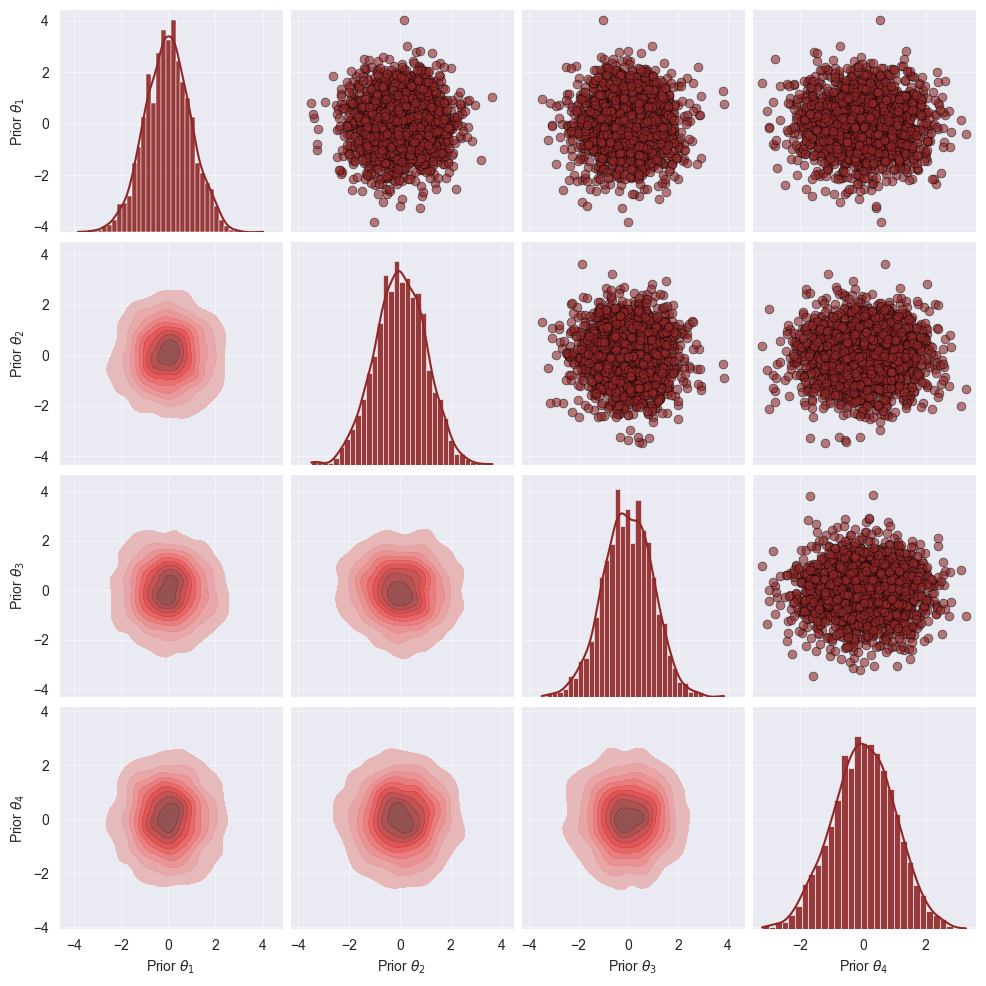

In [16]:
f = bf.diagnostics.plot_prior_2d(simulator=simulator)

## Adapter

Finally, we need to ensure that the simulator outputs are compatible with the neural approximator we train on. To configure the outputs, we use BayesFlow's `Adapter` module, which provides multiple flexible functionalities, from standardization to renaming, and so on. 

In [10]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .broadcast("n_obs")
    .convert_dtype("float64", "float32")
    .standardize(exclude=["n_obs"])
    .rename("x", "summary_variables")
    .rename("theta", "inference_variables")
    .rename("n_obs", "inference_conditions")
)

In [11]:
sample_data = simulator.sample((2,))
processed_data = adapter(sample_data, batch_size=2)
print(processed_data["inference_conditions"].shape)
print(processed_data["inference_variables"].shape)
print(processed_data["summary_variables"].shape)

(2, 1)
(2, 4)
(2, 50, 4)


# Defining the Neural Approximator

## Summary Network

Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. Exchangeability in data means that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. In other words, the data is permutation invariant. For that, we will use a `DeepSet` which does exactly that. This network will take (at least) 3D tensors of shape `(batch_size, n_obs, D)` and reduce them to 2D tensors of shape `(batch_size, summary_dim)`, where `summary_dim` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a permutation-invariant network with `summary_dim = 10`:

In [12]:
summary_net = bf.networks.DeepSet(summary_dim=10)

## Inference Network

In [13]:
inference_net = bf.networks.CouplingFlow(subnet_kwargs=dict(widths=(64, 64)))

## Approximator

In [14]:
approximator = bf.approximators.ContinuousApproximator(
    summary_network=summary_net,
    inference_network=inference_net,
    adapter=adapter
)

## Generating Dataset

In [15]:
batch_size = 256
epochs = 100

training_dataset = bf.datasets.OfflineDataset(
    data=simulator.sample((5000,)), 
    batch_size=batch_size, 
    adapter=adapter
)

validation_dataset = bf.datasets.OfflineDataset(
    data=simulator.sample((300,)), 
    batch_size=batch_size, 
    adapter=adapter
)

AttributeError: 'int' object has no attribute 'shape'

In [22]:
training_dataset

## Optimizer

In [71]:
initial_learning_rate = 5e-4
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=epochs*training_dataset.num_batches,
    alpha=1e-8
)

optimizer = keras.optimizers.AdamW(learning_rate=scheduled_lr, clipnorm=1.0)

## Compilation and Training

In [72]:
approximator.compile(optimizer=optimizer)

In [73]:
history = approximator.fit(
    epochs=epochs,
    num_batches=512,
    batch_size=batch_size,
    simulator=simulator  
)

INFO:bayesflow:Building dataset from simulator instance of SequentialSimulator.
INFO:bayesflow:Using 20 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
188/512 ━━━━━━━━━━━━━━━━━━━━ 1:20 247ms/step - loss: nan - loss/inference_loss: nan

KeyboardInterrupt: 

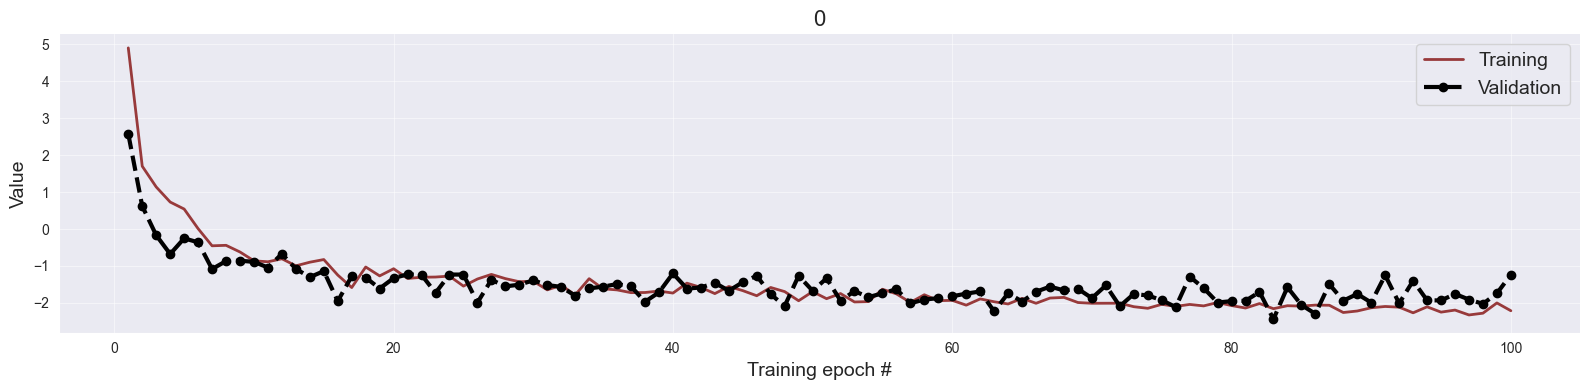

In [31]:
import pandas as pd

f = bf.diagnostics.plot_losses(
    train_losses=pd.DataFrame(history.history['loss']),
    val_losses=pd.DataFrame(history.history['val_loss'])
)

## Validation Phase

In [38]:
n_samples = 5000

conditions = {
    "x": np.array([[0.0, 0.0, 0.0, 0.0]]).astype(np.float32),
}

samples = approximator.sample(conditions=conditions, num_samples=n_samples, batch_size=1)

theta_samples = samples["theta"]

ValueError: input operand has more dimensions than allowed by the axis remapping